## 신용카드 사기 거래 탐지 AI 경진대회

- 참가자: 김승우, 정연호, 이경선
- 목표: 다양한 방법론을 적용하고 그 중에서 가장 f1 score가 높은 방법 찾기.


### Contents
1. TSNE를 이용한 train set과 validation set 시각화로 데이터 파악
2. Feature engineering- 각 feature별 히스토그램을 그리고 필요없는 feature를 제거하기
3. pycrate을 이용하여 다양한 방법의 anomaly detection 방법론을 적용하고 그 중에서 가장 f1 score가 높은 것을 찾기. 
4. Autoencoder기반 데이콘 코드 공유 구현, 다양한 방식으로 바꿔보기(차원 수 변화, 더 깊게 쌓기, 활성화 함수 바꾸기:leakyrelu>tanh 등등)
5. 결론

### Import

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
#GPU 사용하기 위한 코드
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

NameError: name 'torch' is not defined

### 시드 고정 작업

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(200)

### 데이터 불러오기

In [3]:
train_df = pd.read_csv('./input/train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('./input/val.csv')
val_df = val_df.drop(columns=['ID'])

#사기거래 데이터만 따로 뽑기.
#이후 시각화에 쓰기 위함이다. 
val_fraud=val_df[val_df['Class']==1]

#validation set에서 class 제거. 
#이 set으로 class를 예측한 후 원래 class와 비교하여 우리가 고른 방법의 f1 score를 확인할 수 있다. 
val_re=val_df.drop(columns=['Class'])

In [5]:
print(val_df.head())
print(train_df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


### 1. TSNE를 이용한 train data와 validation data 시각화

#### 1-1. train set 시각화
- train set은 데이터가 너무 커서 5000개 random sample을 뽑아서 시각화했다.

In [7]:
#데이터 차원 확인
print(train_df.shape)
print(val_df.shape)

(113842, 30)
(28462, 31)


In [46]:
sample_X5=train_df.sample(5000)

In [47]:
tsne = TSNE(n_components=2, random_state=0)
X_t5 = tsne.fit_transform(sample_X5)

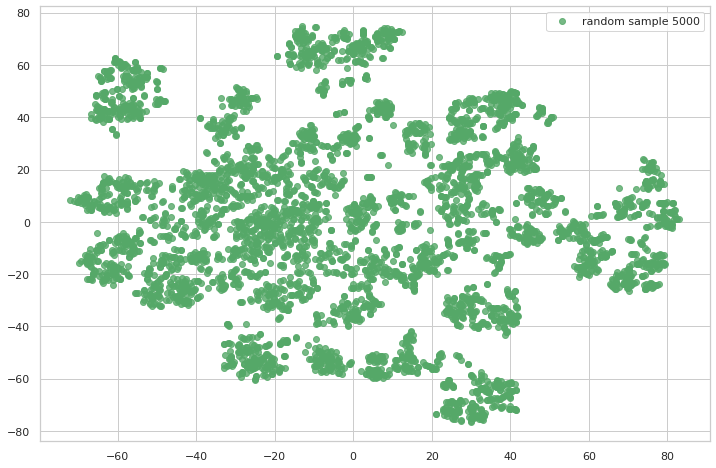

In [48]:
plt.figure(figsize=(12, 8))
plt.scatter(X_t5[:, 0], X_t5[:, 1], marker='o', color='g', linewidth=1, alpha=0.8, label='random sample 5000')

plt.legend(loc='best');
plt.show();

#### 1-2. validation set 시각화

In [13]:
X = val_df.drop('Class', axis = 1).values
Y = val_df["Class"]

In [7]:
tsne = TSNE(n_components=2, random_state=0)
X_t3 = tsne.fit_transform(val_df)

C:\Users\User\Pictures\ANACONDA\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\User\Pictures\ANACONDA\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


C:\Users\User\Pictures\ANACONDA\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\User\Pictures\ANACONDA\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


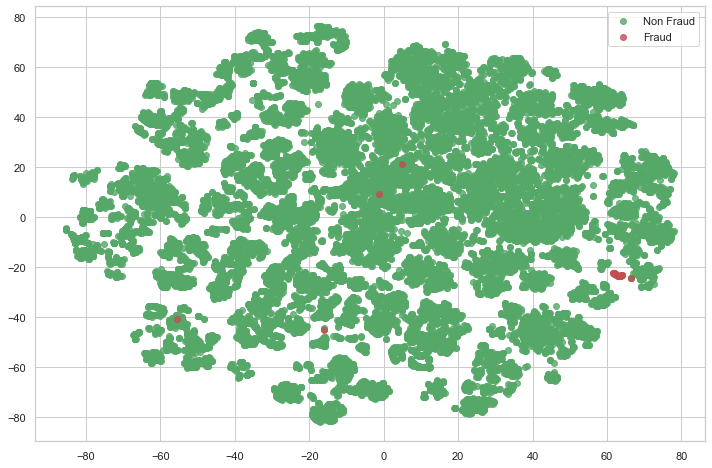

In [15]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

- 모든 사기거래가 모여있지는 않다.
- 가운데 부분을 보면 정상거래와 상당히 유사한 사기거래가 있다.
- 오른쪽에 찍힌 점 3개가 대부분의 사기거래라고 추정된다.


### 2. Feature engineering- 각 feature별 히스토그램을 그리고 필요없는 feature를 제거하기


#### 2-1. 각 feature별 히스토그램 그리기.
- validation set의 각 feature별 히스토그램을 그리고 사기거래가 어떻게 분포되어있는지 나타내자.

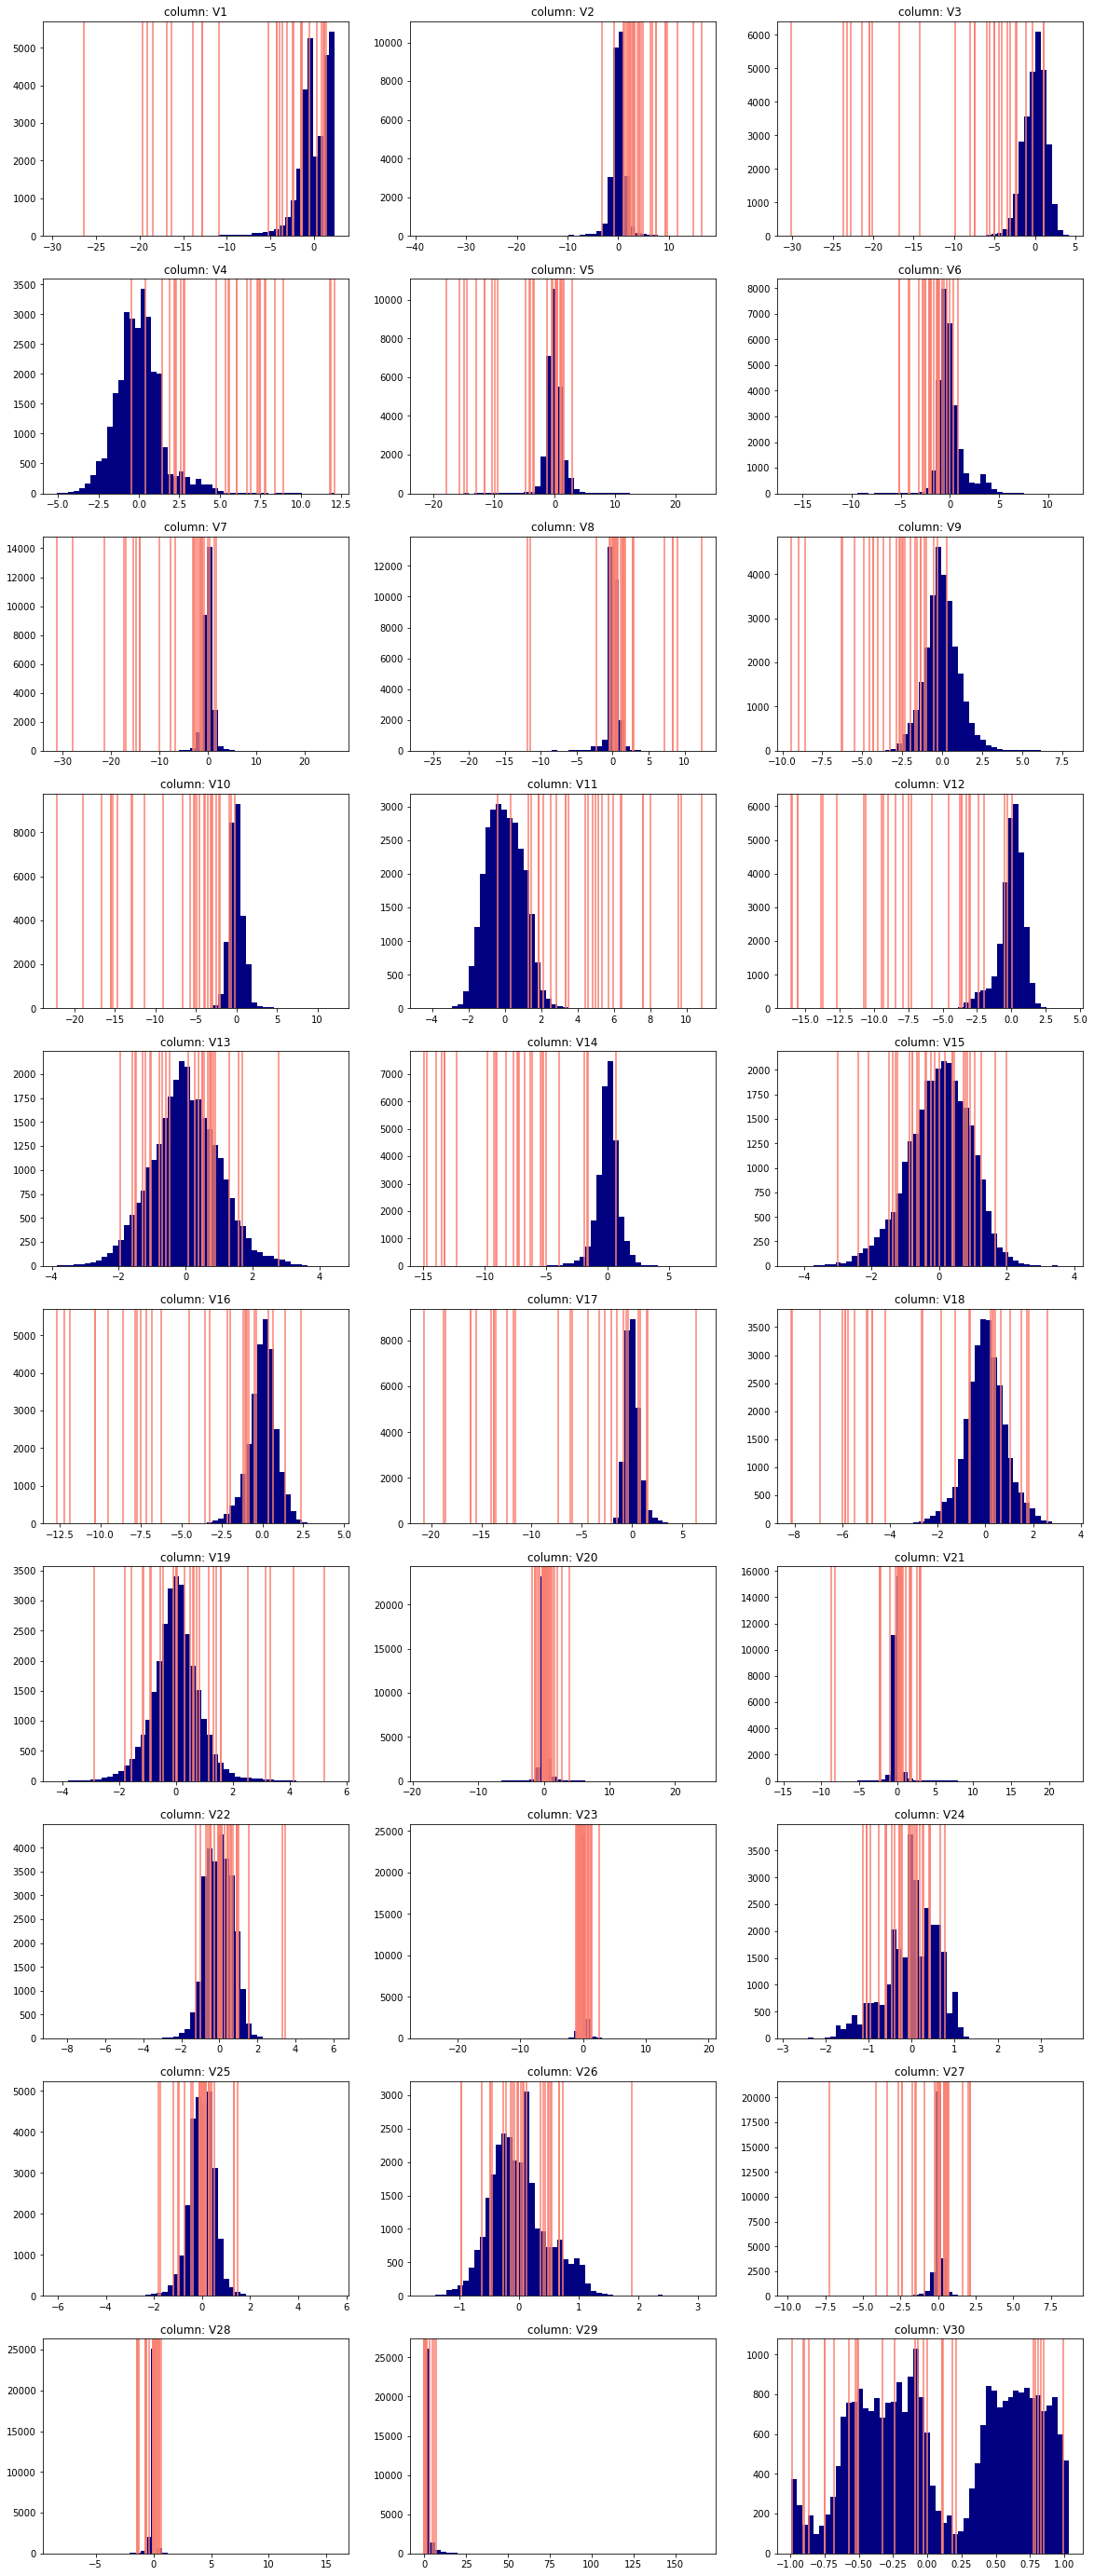

In [95]:
#sub plot 객체 지정
sub_plots=plt.subplots(10,3,figsize=(20,50))
fig = sub_plots[0]
graph = sub_plots[1]

#for문 만들기 위한 수 지정
v=val_re.shape[1]
s=val_fraud.shape[0]

for i in range(0,v):
    a=i//3
    b=i%3
    graph[a][b].hist(val_re.iloc[:,i],bins=50,color='navy')
    graph[a][b].set_title(f'column: V{i+1}')
    for j in range(0,s-1):
        graph[a][b].axvline(val_fraud.iloc[j,i],color="salmon")

plt.show()    

- 정상 거래가 많이 있는 수치에서 이상치가 있다면 그 column은 이상치 판별에 큰 도움이 되지 않을 것이다.
- 그런 column을 제거하고 학습을 시키면 더 학습이 잘 되고 시간이 덜 걸릴 것이다.
- 육안으로 확인했으니 이제 수치상으로 어떤 column을 제거할지 계산해보자

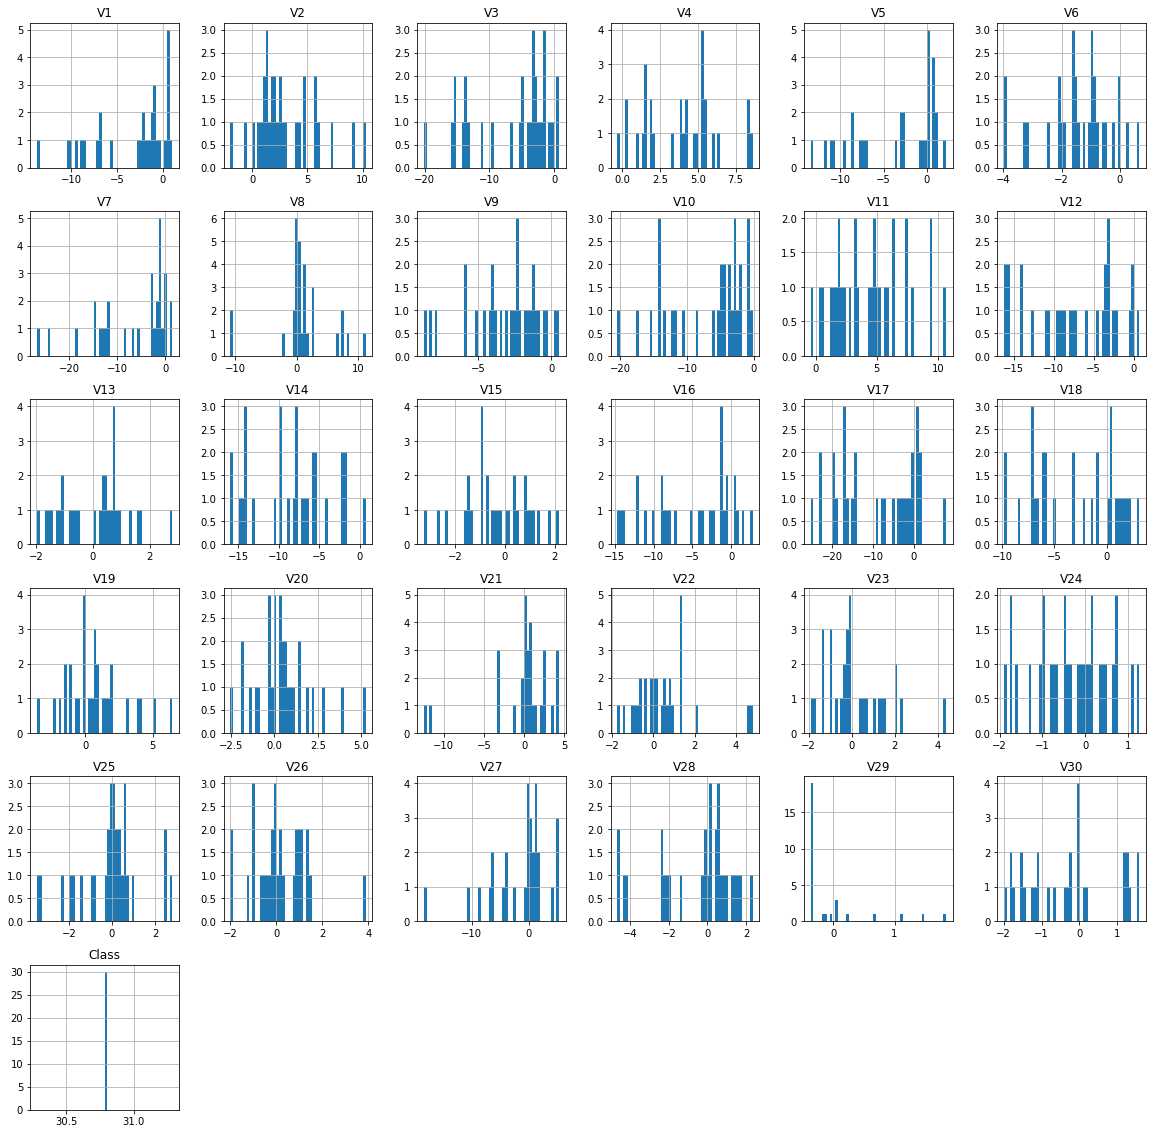

In [118]:
#일단 각 column별 수치 normalization하기
#apply로 인해 각 컬럼별로 시행
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

#각 column별로 normalization된 사기거래의 값을 히스토그램으로 나타내자.
val_df_ss = mean_norm(val_df)
val_df_ss_fraud=val_df_ss.loc[index]
val_df_ss_fraud.hist(bins = 50, figsize = (20,20))
plt.show()

"아래 dataset과 model에 대한 설명"

In [17]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(dim,dim*4),
            nn.BatchNorm1d(dim*4),
            nn.LeakyReLU(),
            nn.Linear(dim*4, dim*8),
            nn.BatchNorm1d(dim*8),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(dim*8,dim*4),
            nn.BatchNorm1d(dim*4),
            nn.LeakyReLU(),
            nn.Linear(dim*4,dim),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x


In [155]:
for a in range(0,12):
    df=[1,2,3]
    print(f'df{df}') if a//3==0 else d=Na


df[1, 2, 3]
df[1, 2, 3]
df[1, 2, 3]


In [19]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            if epoch%5==0: print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])') 
            

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [177]:
#표준화된 값의 제곱의 합이 클 수록 이상치들은 평균과 멀리 떨어져있다.
#표준화 제곱합을 구해 작은 순서대로 나열하자. 값이 작을 수록 덜 중요한 column이라고 볼 수 있다.
val_df_ss_frauds=val_df_ss_fraud**2
val_df_ss_fraudss=val_df_ss_frauds.sum()
val_in=pd.DataFrame({"ss":val_df_ss_fraudss})
val_in=val_in.sort_values('ss',ascending=False)
val_in=val_in.reset_index()

print(val_in)

    index            ss
0   Class  28431.001054
1     V17   4887.567869
2      V7   3031.531722
3     V14   2715.521810
4     V12   2449.949704
5     V10   2440.117488
6      V3   2318.483142
7     V16   1623.472952
8      V5   1020.893449
9      V1    837.261995
10    V11    817.454015
11    V27    811.313837
12    V18    720.152848
13     V4    627.950347
14     V8    610.439513
15     V2    486.825038
16     V9    445.115537
17    V21    427.996096
18    V19    158.207126
19    V28    124.140565
20     V6     96.866704
21    V20     85.070018
22    V22     69.728692
23    V25     62.262633
24    V23     56.806406
25    V15     51.495540
26    V26     41.461606
27    V30     40.175201
28    V13     37.993958
29    V24     24.073152
30    V29      9.806658


In [178]:
print(val_in.loc[[1],:])

  index           ss
1   V17  4887.567869


In [195]:
for i in range(1,s+1):
    ran=range(1,i)
    ind=val_in.loc[ran,:]["index"]
    print(ind)
    train_ma=train_df.drop(columns=[ind])
    print(train_ma)


Series([], Name: index, dtype: object)


KeyError: '[()] not found in axis'

In [ ]:
for i in range(1,s+1):
    ran=range(1,i)
    train_ma=val_in.loc[ran,:]

    DIM=train_ma.shape[0]

    train_dataset = MyDataset(df=train_ma, eval_mode=False)
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

    val_dataset = MyDataset(df = val_1, eval_mode=True)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

    model = nn.DataParallel(AutoEncoder(DIM))
    model.eval()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

    trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
    trainer.fit()

In [39]:
val_fraud=val_df[val_df["Class"]==1]
print(val_fraud)
index=val_fraud.index.to_list()
print("\n Index info")
print(index)

              V1         V2         V3         V4         V5        V6  \
71     -3.043541  -3.157307   1.088463   2.288644   1.359805 -1.064823   
641     0.316459   3.809076  -5.615159   6.047445   1.554026 -2.651353   
677     0.857321   4.093912  -7.423894   7.380245   0.973366 -2.730762   
836    -1.426623   4.141986  -9.804103   6.666273  -4.749527 -2.073129   
1196  -16.367923   9.223692 -23.270631  11.844777  -9.462037 -2.450444   
1201  -16.917468   9.669900 -23.736443  11.824990  -9.830548 -2.514829   
1547  -18.474868  11.586381 -21.402917   6.038515 -14.451158 -4.146524   
3055   -3.896583   4.518355  -4.454027   5.547453  -4.121459 -1.163407   
4039    1.159373   2.844795  -4.050680   4.777701   2.948980 -2.010361   
4267  -13.897206   6.344280 -14.281666   5.581009 -12.887133 -3.146176   
4396  -19.139733   9.286847 -20.134992   7.818673 -15.652208 -1.668348   
7702   -2.335655   2.225380  -3.379450   2.178538  -3.568264  0.316814   
9326    1.080433   0.962831  -0.278065

In [31]:
import pandas as pd
import numpy as np

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

val_df_ss = mean_norm(val_df)
print(val_df_ss)

             V1        V2        V3        V4        V5        V6        V7  \
0     -0.177780  0.696225  0.695418 -0.159472  0.376984 -0.177240  0.554467   
1      0.495965  0.203369 -0.115281  1.499718  0.848996  1.326225  0.087678   
2      0.590767  0.356999  0.128418  1.847717 -0.066091 -0.794527  0.451478   
3      0.477610 -0.202902  0.257491  0.386141  0.187812  1.290875 -0.371745   
4     -1.559174  1.618569  0.988350 -1.722510  0.232405 -0.624389  1.767928   
...         ...       ...       ...       ...       ...       ...       ...   
28457 -0.285576  0.892088 -0.209812  0.657694  0.394232 -0.424031  0.910213   
28458 -0.398567  0.365291 -0.606110 -0.299429  0.678200 -0.575038  0.646269   
28459 -0.234077  0.809992 -0.113350  0.697216  0.436601 -0.454964  1.071016   
28460  1.053844 -0.110421 -0.798960  0.165597 -0.003554 -0.548548  0.009865   
28461 -0.127112  0.329223  0.467476  0.489565 -0.280113  0.496386 -0.593697   

             V8        V9       V10  ...       V22 

In [44]:
val_df_ss_fraud=val_df_ss.loc[index]
print(val_df_ss_fraud)

              V1         V2         V3        V4         V5        V6  \
71     -1.579014  -1.968181   0.724821  1.627420   1.021441 -0.810309   
641     0.161341   2.371708  -3.745009  4.302460   1.166909 -2.038070   
677     0.441488   2.549154  -4.951034  5.250978   0.732005 -2.099521   
836    -0.741511   2.579103  -6.538107  4.742863  -3.554333 -1.590602   
1196   -8.480551   5.744884 -15.517296  8.428267  -7.083914 -1.882594   
1201   -8.765195   6.022861 -15.827890  8.414186  -7.359922 -1.932419   
1547   -9.571870   7.216782 -14.271945  4.296105 -10.820672 -3.195130   
3055   -2.020858   2.813572  -2.970792  3.946629  -3.083922 -0.886600   
4039    0.597940   1.770984  -2.701848  3.398816   2.211703 -1.542028   
4267   -7.200811   3.951080  -9.523649  3.970510  -9.649247 -2.420996   
4396   -9.916246   5.784228 -13.426520  5.562996 -11.720235 -1.277356   
7702   -1.212355   1.385103  -2.254287  1.549061  -2.669590  0.258891   
9326    0.557052   0.598566  -0.186351  1.951000   

In [46]:
val_df_ss_fraud=abs(val_df_ss_fraud)

In [47]:
val_df_ss_fraud.sum()

V1       109.132803
V2        94.358654
V3       199.055334
V4       117.180102
V5       121.212697
V6        44.029972
V7       204.621073
V8        83.495298
V9        92.732229
V10      209.471239
V11      132.041924
V12      222.479738
V13       29.074367
V14      251.666041
V15       31.992814
V16      168.733092
V17      296.792380
V18      116.963690
V19       50.857020
V20       35.710556
V21       70.708639
V22       31.490314
V23       30.823325
V24       21.567701
V25       29.807588
V26       26.109745
V27      103.371428
V28       44.620707
V29       12.632522
V30       28.926024
Class    923.542111
dtype: float64

In [36]:
for i in 

1.5790139747048917

In [28]:
abs(val_df_ss["V1"][71])

array([[-0.1777828 ,  0.69623726,  0.69543061, ..., -0.35250264,
        -1.99699312, -0.03248306],
       [ 0.49597343,  0.20337215, -0.11528319, ..., -0.22556347,
        -1.99682475, -0.03248306],
       [ 0.59077699,  0.35700505,  0.12842026, ..., -0.2253965 ,
        -1.99631967, -0.03248306],
       ...,
       [-0.23408074,  0.8100065 , -0.11335212, ..., -0.11532133,
         1.63881874, -0.03248306],
       [ 1.05386235, -0.1104227 , -0.79897392, ..., -0.3566769 ,
         1.63911338, -0.03248306],
       [-0.12711389,  0.32922889,  0.4674842 , ..., -0.32612133,
         1.63919756, -0.03248306]])

array([-0.1777828 ,  0.69623726,  0.69543061, -0.15947447,  0.376991  ,
       -0.17724262,  0.55447691,  0.05483876, -0.67088999, -0.33612993,
        0.99716533,  0.84172605,  1.00213113, -0.48556967,  0.16092449,
        0.84989266, -0.66770914,  0.56517958,  0.55833357,  0.27657855,
       -0.35232708, -0.88027719, -0.2079428 , -0.64062346, -0.13669328,
        0.19323453,  0.62587991,  0.27389654, -0.35250264, -1.99699312,
       -0.03248306])

             V1        V2        V3        V4        V5        V6        V7  \
0     -0.177780  0.696225  0.695418 -0.159472  0.376984 -0.177240  0.554467   
1      0.495965  0.203369 -0.115281  1.499718  0.848996  1.326225  0.087678   
2      0.590767  0.356999  0.128418  1.847717 -0.066091 -0.794527  0.451478   
3      0.477610 -0.202902  0.257491  0.386141  0.187812  1.290875 -0.371745   
4     -1.559174  1.618569  0.988350 -1.722510  0.232405 -0.624389  1.767928   
...         ...       ...       ...       ...       ...       ...       ...   
28457 -0.285576  0.892088 -0.209812  0.657694  0.394232 -0.424031  0.910213   
28458 -0.398567  0.365291 -0.606110 -0.299429  0.678200 -0.575038  0.646269   
28459 -0.234077  0.809992 -0.113350  0.697216  0.436601 -0.454964  1.071016   
28460  1.053844 -0.110421 -0.798960  0.165597 -0.003554 -0.548548  0.009865   
28461 -0.127112  0.329223  0.467476  0.489565 -0.280113  0.496386 -0.593697   

             V8        V9       V10  ...       V22 